# Imports

In [152]:
import main
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from enum import IntEnum

# Packaging and Training
Package vans for a few "days" and stop only when we think we have learned the best way to do so. Store information about every time we packaged the vans in `training_iterations`.

Note that learning can take several minutes, but since its progress is saved in a file locally it won't have to learn it all again.

In [153]:
N_PACKAGES = 10_000

training_iterations: list[dict] = []

done_learning = False

while not done_learning:
    training_iteration = main.package_vans(N_PACKAGES)
    training_iterations.append(training_iteration)
    done_learning = training_iteration["done_learning"]

print("Done learning!")

Done learning!


# Data
Get the data from the last iteration of training.

In [154]:
last_iteration = training_iterations[-1]
df = last_iteration["df"]
df["FörtjänstEfterStraff"] = df["Förtjänst"] - np.where( df["Deadline"] < 0, df["Deadline"]**2, 0 )

# Get Packages Function
Create a function for retrieving the packages of a selected van, or to retrieve the packages left in the warehouse.

In [155]:
class VanNumber(IntEnum):
    NOT_DELIVERED = -1
    ONE = 0
    TWO = 1
    THREE = 2
    FOUR = 3
    FIVE = 4
    SIX = 5
    SEVEN = 6
    EIGHT = 7
    NINE = 8
    TEN = 9

def get_packages(van_number: VanNumber) -> DataFrame:
    return df[ (df["Delivered"] == van_number) ]

# Plot
Plot stuff for each van + the packages still left.

In [156]:
plt.style.use("seaborn-v0_8-notebook")

In [157]:
def plot_packages(packages: DataFrame, title: str) -> None:
    columns = ["Vikt", "FörtjänstEfterStraff"] # Columns of interest
    _, axes = plt.subplots(1, 2, figsize=(14, 4))  # Subplots with 1 row, 2 columns

    for i, column in enumerate(columns):
        mean_value = packages[column].mean()
        variance = packages[column].var()
        std_dev = packages[column].std()

        ax = axes[i]
        ax.hist(packages[column], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
        ax.set_title(f"{title}: '{column}'")
        ax.set_xlabel(column)
        ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1, label=f"Mean = {mean_value:.2f}") # Nice line for mean with label
        ax.legend()

        # Standard deviation and variance in a nice rounded box
        stats_text = (
            f"Variance: {variance:.2f}\n"
            f"Std Deviation: {std_dev:.2f}"
        )
        ax.text(
            0.95, 0.85, stats_text, 
            transform=ax.transAxes, fontsize=10, 
            verticalalignment='top', horizontalalignment='right', 
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.7)
        )
    plt.tight_layout()
    plt.show()

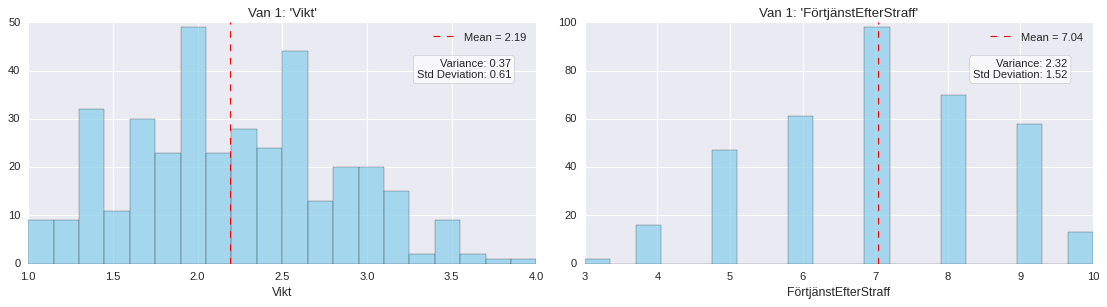

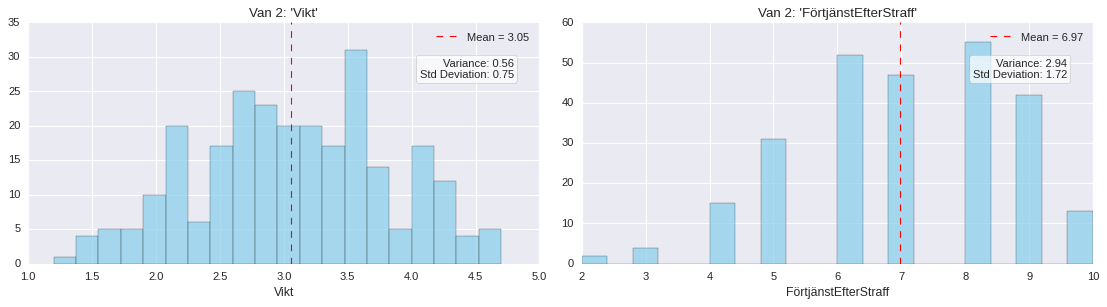

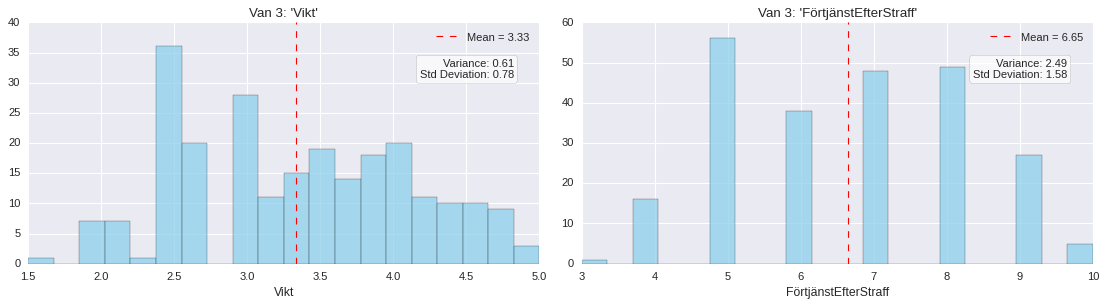

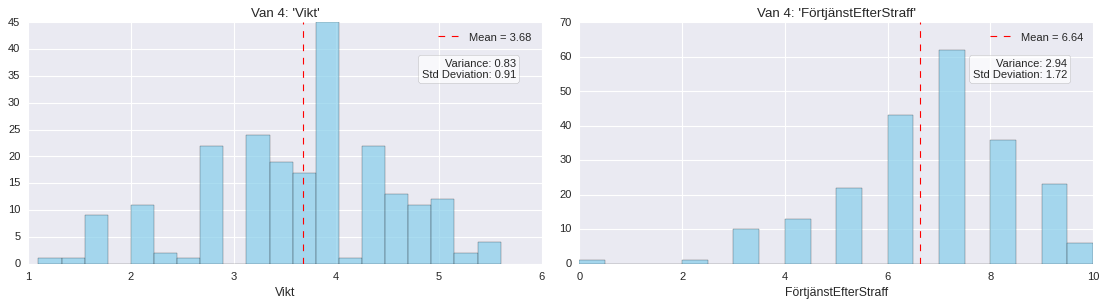

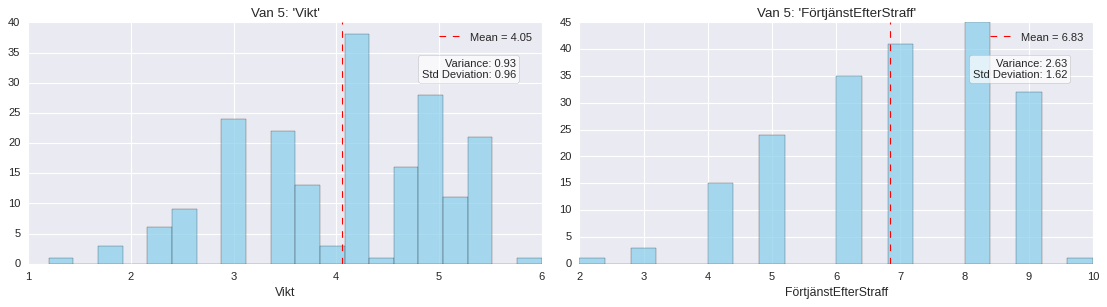

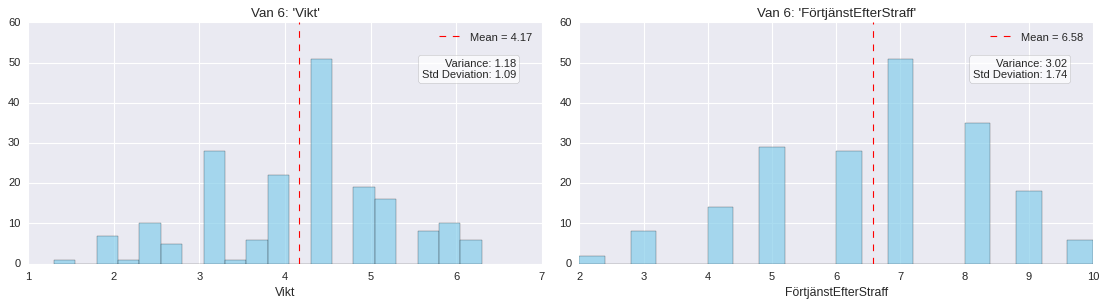

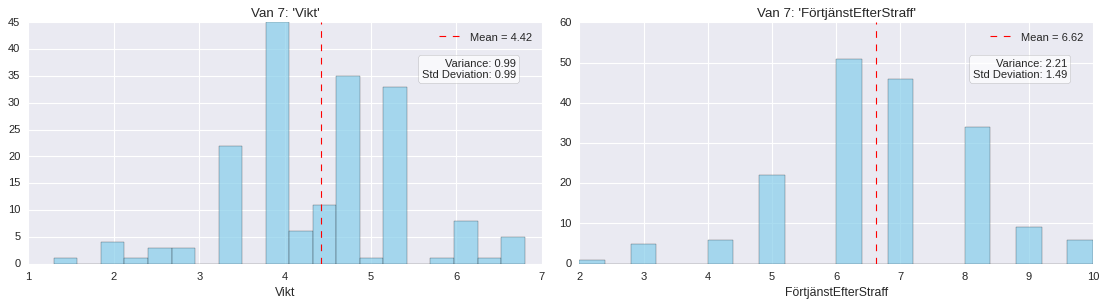

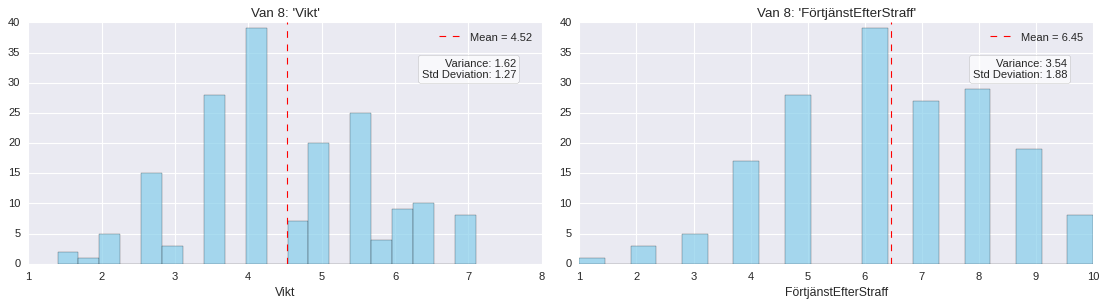

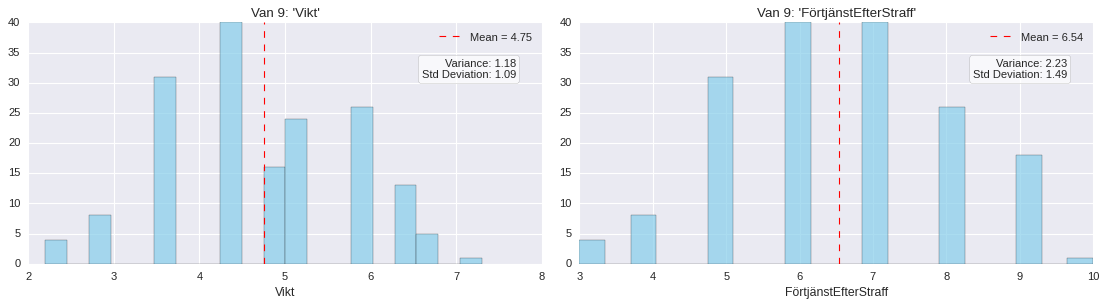

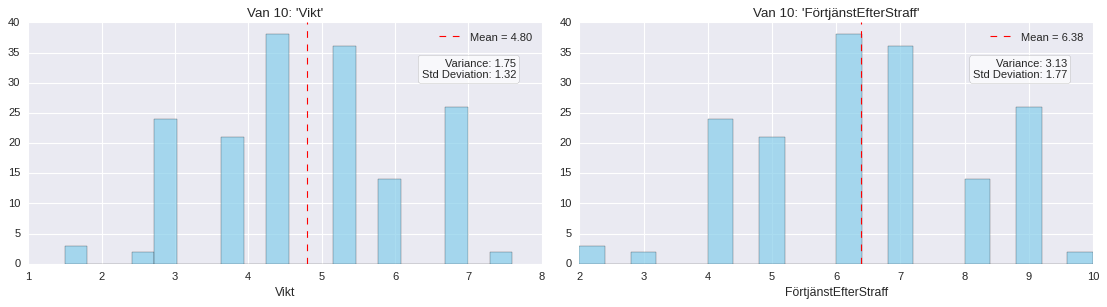

In [158]:
for van_number in VanNumber:
    if van_number > VanNumber.NOT_DELIVERED:
        plot_packages( get_packages(van_number), f"Van {van_number+1}" )

Since the vans are filled up one by one, the first van is going to get the packages of highest priority, in other words, the packages with the least amount of weight and most profit. This is why the next van on avarage has heavier packages and lower profits than the previous.

Plot undelivered packages lastly:

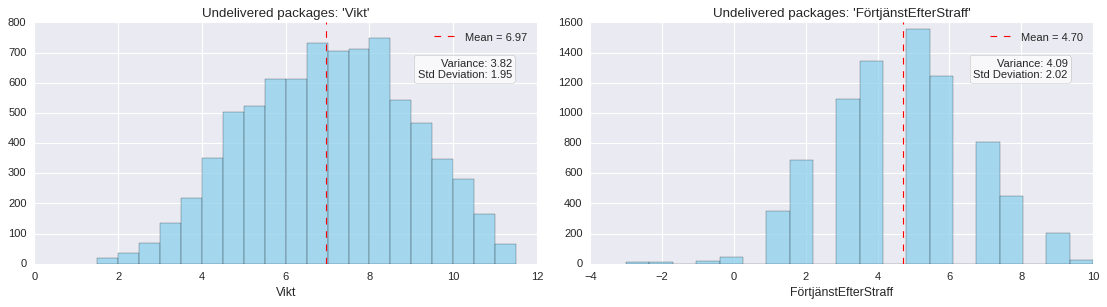

In [159]:
plot_packages( get_packages(VanNumber.NOT_DELIVERED), "Undelivered packages" )